# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


import packages

In [1]:
import os
import json
from planktonclas import test_utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,roc_auc_score
from planktonclas.data_utils import load_image, load_class_names
from planktonclas import paths, plot_utils
from planktonclas.plot_utils import create_pred_path,plt_conf_matrix
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

ModuleNotFoundError: No module named 'planktonclas'

Import data

In [2]:

# User parameters to set
TIMESTAMP = '2023-06-05_143422'           # timestamp of the model
SPLIT_NAME = 'test_RJB'                   # dataset split to predict
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction
TOP_K = 5                             # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load clas names
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)
data = pd.DataFrame(pred_dict)
data[['filenames', 'true_lab','pred_lab']].head(5)
data['in_top5'] = data.apply(lambda row: row['true_lab'] in row['pred_lab'], axis=1)
data['top1_correct'] = data.apply(lambda row: row['true_lab'] == row['pred_lab'][0], axis=1)
data['true_label']=class_names[data['true_lab']]
data['top1']=data.apply(lambda row: class_names[row['pred_lab'][0]], axis=1)
data['probability']=data.apply(lambda row: row['pred_prob'][0], axis=1)


Loading class names...


In [51]:
os.listdir("./data")

['.gitignore',
 'change_images',
 'create_dataset_files.py',
 'dataset_files',
 'dataset_files_og',
 'dataset_files_old',
 'demo-dataset_files',
 'images',
 'images_old',
 'performance_data.csv',
 'samples']

In [81]:
data = pd.read_csv(r"./data/performance_data.csv")

Create Folder

In [15]:
folder_path=os.path.join(paths.get_timestamped_dir(),"results")
# folder_path = "models/2023-06-05_143422/results"  # Replace with the desired folder path
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
print(folder_path, "created")

/srv/phyto-plankton-classification/models/2023-06-05_143422/results created


## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [3]:
true_lab, pred_lab = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])

top1 = test_utils.topK_accuracy(true_lab, pred_lab, K=1)
top5 = test_utils.topK_accuracy(true_lab, pred_lab, K=5)

print('Top1 accuracy: {:.1f} %'.format(top1 * 100))
print('Top5 accuracy: {:.1f} %'.format(top5 * 100))

labels = range(len(class_names))
print('\n')
print('Micro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro recall (no labels): {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro precision (no labels): {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro F1 score (no labels): {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

Top1 accuracy: 90.3 %
Top5 accuracy: 99.5 %


Micro recall: 90.3 %
Macro recall: 90.3 %
Macro recall (no labels): 90.3 %
Weighted recall: 90.3 %


Micro precision: 90.3 %
Macro precision: 91.7 %
Macro precision (no labels): 91.7 %
Weighted precision: 91.7 %


Micro F1 score: 90.3 %
Macro F1 score: 90.2 %
Macro F1 score (no labels): 90.2 %
Weighted F1 score: 90.2 %


## Computing the confusion matrix

### Standard confusion matrix

In [62]:
def plot_confusion_matrices(data, save_path=None, aimed=False, weighted=False,comments="normal"):
    """
    Plot confusion matrices and weighted confusion matrices for different thresholds using the provided data.

    Args:
        data (pandas.DataFrame): DataFrame containing the necessary data for plotting.
        save_path (str): Path where the plots will be saved.
        aimed (bool): Flag indicating whether the confusion matrices are aimed or not.
        weighted (bool): Flag indicating whether to compute weighted confusion matrices.
    """

    # Define the labels
    class_names = np.unique(data["top1"])

    # Define the range for iterations
    myrange = np.arange(0, 1, 0.25)

    # Create the directory for saving the plots
    pred_path = create_pred_path(save_path, dir="confusion",aimed=aimed, weighted=weighted, comments=comments)


    # Iterate over the range
    for i in myrange:
        # Get the current time
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"[{current_time}] Plotting Confusion Matrix for {i}")

        # Filter the data based on a condition
        slice = data[data["probability"] > i]

        # Extract true labels and predicted labels
        y_true = np.array(slice["true_label"])
        y_pred = np.array(slice["top1"])

        y_true = y_true.astype(str)
        y_pred = y_pred.astype(str)
        # Compute the confusion matrix
        weights = np.array(slice["probability"]) if weighted else None
        conf_mat = confusion_matrix(y_true, y_pred, labels=np.unique(y_pred), sample_weight=weights)

        # Normalize the confusion matrix
        normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

        # Plot the confusion matrix using the custom function plt_conf_matrix
        fig, ax = plt_conf_matrix(normed_conf, class_names)

        # Save the plot
        # Determine the file name suffix based on weighted option
        file_suffix = f"weighted_{i:.2f}" if weighted else f"_{i:.2f}"

        # Save the confusion matrix plot
        fig.savefig(f"{pred_path}/confusion_matrix{file_suffix}.jpg", bbox_inches='tight')
        plt.close(fig)
    print(f"Saved in {pred_path}")


In [63]:
plot_confusion_matrices(data, save_path=False)

[2023-10-04 15:13:03] Plotting Confusion Matrix for 0.0
[2023-10-04 15:13:06] Plotting Confusion Matrix for 0.25
[2023-10-04 15:13:08] Plotting Confusion Matrix for 0.5
[2023-10-04 15:13:11] Plotting Confusion Matrix for 0.75
Saved in /srv/phyto-plankton-classification/models/2023-06-05_143422/results/confusion/normal


### Weighted confusion matrix
We weight each count in the confusion matrix by the probability of the prediction.

In [64]:
# Create the directory for saving the plots
plot_confusion_matrices(data,save_path=False,weighted=True)

[2023-10-04 15:13:22] Plotting Confusion Matrix for 0.0
[2023-10-04 15:13:24] Plotting Confusion Matrix for 0.25
[2023-10-04 15:13:27] Plotting Confusion Matrix for 0.5
[2023-10-04 15:13:30] Plotting Confusion Matrix for 0.75
Saved in /srv/phyto-plankton-classification/models/2023-06-05_143422/results/confusion/confusion_weighted


### Metrics evolution in function of cut-off 
The evolution of differnt metrics is shown for different cut-off values. All data below this cut-off is discarted when plotting new metrics.

In [65]:
def plot_evolution_cut_off(data, save_path=False,comments=""):
    """
    Plot the evolution of metrics with varying cutoff probability.

    Args:
        data (DataFrame): Input data containing "probability", "top1", and "true_label" columns.
        save_path (str): Path where the plots will be saved.

    Returns:
        None (plots are displayed and saved)
    """
    myrange = np.arange(0, 1, 0.02)

    pred_path = create_pred_path(save_path, dir="cut_off_changes",comments=comments)

    for cl in np.unique(data["top1"]):
        print(f"Plotting cutoff probability for {cl}")

        metrics = []
        data_slice = []

        for i in myrange:
            slice_data = data[data["probability"] > i]
            data_slice.append(compute_data_slice(slice_data, cl))

            TP, FP, FN, TN = calculate_confusion_matrix(slice_data, cl)
            precision, recall, outer_precision, outer_recall, f1_score, accuracy, specificity, fpr, fnr, auc_roc = compute_metrics(slice_data, cl, TP, FP, FN, TN)

            metrics.append((precision, recall, outer_precision, outer_recall, f1_score, accuracy, specificity, fpr, fnr, auc_roc))

        plot_metrics(myrange, metrics, data_slice, cl, pred_path)

    print("Plots saved in:", pred_path)




def compute_data_slice(slice_data, cl):
    return np.sum(slice_data['top1'] == cl) / np.sum(data['top1'] == cl)


def calculate_confusion_matrix(slice_data, cl):
    TP = np.sum((slice_data["true_label"] == cl) & (slice_data["top1"] == cl))
    FP = np.sum((slice_data["true_label"] != cl) & (slice_data["top1"] == cl))
    FN = np.sum((slice_data["true_label"] == cl) & (slice_data["top1"] != cl))
    TN = np.sum((slice_data["true_label"] != cl) & (slice_data["top1"] != cl))
    return TP, FP, FN, TN


def compute_metrics(slice_data, cl, TP, FP, FN, TN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    outer_precision = TP / np.sum(slice_data["top1"] == cl)
    outer_recall = TP / np.sum(slice_data["true_label"] == cl)

    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)
    fnr = FN / (FN + TP)

    if np.sum((slice_data["true_label"] == cl)) != 0:
        auc_roc = roc_auc_score((slice_data["true_label"] == cl).astype(int), slice_data["probability"])
    else:
        auc_roc = 0

    return precision, recall, outer_precision, outer_recall, f1_score, accuracy, specificity, fpr, fnr, auc_roc


def plot_metrics(myrange, metrics, data_slice, cl, pred_path):
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')
    colors = cmap(np.linspace(0, 1, 12))

    plt.plot(myrange, [m[0] for m in metrics], label="Precision", linestyle='-', marker='o', color=colors[0])
    plt.plot(myrange, [m[1] for m in metrics], label="Recall", linestyle='--', marker='s', color=colors[1])
    plt.plot(myrange, data_slice, label="Loss of Predictions", linestyle='-', marker='*', color=colors[4])

    plt.plot(myrange, [m[2] for m in metrics], label="Outer Precision", linestyle=':', marker='^', color=colors[2])
    plt.plot(myrange, [m[3] for m in metrics], label="Outer Recall", linestyle='-.', marker='D', color=colors[3])

    plt.plot(myrange, [m[4] for m in metrics], label="F1 Score", linestyle='-', marker='x', color=colors[5])
    plt.plot(myrange, [m[5] for m in metrics], label="Accuracy", linestyle='--', marker='o', color=colors[6])
    plt.plot(myrange, [m[6] for m in metrics], label="Specificity", linestyle=':', marker='s', color=colors[7])
    plt.plot(myrange, [m[7] for m in metrics], label="False Positive Rate", linestyle='-.', marker='^', color=colors[8])
    plt.plot(myrange, [m[8] for m in metrics], label="False Negative Rate", linestyle='-', marker='D', color=colors[9])
    plt.plot(myrange, [m[9] for m in metrics], label="AUC-ROC", linestyle='--', marker='*', color=colors[10])

    plt.legend(loc='best', fontsize='medium')
    plt.xlabel("Cutoff value for probability", fontsize='large')
    plt.ylabel("Metric Score", fontsize='large')
    plt.title(cl, fontsize='x-large')

    plt.xticks(fontsize='medium')
    plt.yticks(fontsize='medium')

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig(f"{pred_path}/{cl.replace('/', '+')}.jpg", bbox_inches='tight')
    plt.close()


In [86]:
plot_evolution_cut_off(data, save_path=False)

Plotting cutoff probability for Actinoptychus
Plotting cutoff probability for Actinoptychus senarius
Plotting cutoff probability for Actinoptychus splendens
Plotting cutoff probability for Appendicularia
Plotting cutoff probability for Asterionella
Plotting cutoff probability for Aulacodiscus argus
Plotting cutoff probability for Bacillaria paxillifer
Plotting cutoff probability for Bacillariophyceae
Plotting cutoff probability for Bacillariophyceae_type1_colony
Plotting cutoff probability for Bacteriastrum
Plotting cutoff probability for Bellerochea horologicalis
Plotting cutoff probability for Biddulphia alternans
Plotting cutoff probability for Biddulphianae
Plotting cutoff probability for Brockmanniella brockmannii
Plotting cutoff probability for Bubbles
Plotting cutoff probability for Centric Diatom
Plotting cutoff probability for Ceratium horridum/C. longipes
Plotting cutoff probability for Chaetoceros
Plotting cutoff probability for Chaetoceros affinis
Plotting cutoff probabilit

### The Proportional and absolute progression of TRUE class is shown


In [7]:
def plot_classwise_progression(data,save_path,comments=""):
    """
    Plot the class-wise progression of TRUE class distribution for different cutoff values.

    Args:
        data (pandas.DataFrame): DataFrame containing the necessary data for plotting.
    """

    # Define the range for iterations
    myrange = np.arange(0, 1, 0.02)

    # Create directory for saving results
    pred_path = create_pred_path(save_path, dir="proportional_progression",comments=comments)


    for cl in np.unique(data["top1"]):
        print(f"Plotting proportional progression for {cl}")
        compo = pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts())
        for j, i in enumerate(myrange):
            slice = data[data["probability"] > i]
            x = slice[slice['top1']==cl]["true_label"].value_counts()
            compo[str(j)] = x


        compo = compo.drop("true_label", axis=1)
        plotdata = compo / compo.sum()
        plotdata1 = plotdata[plotdata > 0.01] * 100
        plotdata2 = compo[plotdata > 0.01]
        plotdata1.columns = myrange
        plotdata2.columns = myrange
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        plotdata1.dropna(how="all").transpose().plot.area(ax=axs[0], legend=False,
                                                          title="proportional progression of TRUE class distribution",
                                                          xlabel="Cutoff value for probability",
                                                          ylabel="Class proportion (%)")
        plotdata2.dropna(how="all").transpose().plot.area(ax=axs[1],
                                                          title="absolute progression of TRUE class distribution",
                                                          xlabel="Cutoff value for probability",
                                                          ylabel="Class count")
        plt.suptitle(cl)

        # Save the plot
        plt.savefig(f"{pred_path}/{cl.replace('/', '+')}.jpg", bbox_inches='tight')
        plt.close()


In [14]:
save_path

NameError: name 'save_path' is not defined

In [8]:
plot_classwise_progression(data,save_path=False)

Plotting proportional progression for Actinoptychus_senarius
Plotting proportional progression for Appendicularia
Plotting proportional progression for Artefacts
Plotting proportional progression for Asterionellopsis_glacialis
Plotting proportional progression for Bacillaria_paxillifer
Plotting proportional progression for Bacteriastrum
Plotting proportional progression for Bellerochea_horologicalis
Plotting proportional progression for Biddulphia_alternans
Plotting proportional progression for Brockmanniella_brockmannii
Plotting proportional progression for Centric_Diatom
Plotting proportional progression for Chaetoceros
Plotting proportional progression for Coscinodiscus_granii
Plotting proportional progression for Crustacea
Plotting proportional progression for Detritus
Plotting proportional progression for Dissodinium
Plotting proportional progression for Ditylum_brightwellii
Plotting proportional progression for Eggs
Plotting proportional progression for Equinoderm_Larvae
Plotting

**Define cutoff - Nic**

In [89]:
# Function to define the cutoff probability for a given class
def define_cutoff(data, cl, p_aim=0.95):
    # Slice the data for the specific class and sort it in descending order based on probability
    slice = data[data["top1"] == cl].sort_values(by="probability", ascending=False).reset_index()
    # Calculate the precision for each position in the slice
    prec_list = np.cumsum(slice["top1_correct"]) / (slice.index + 1)
    # Find the positions where precision exceeds the desired aim
    acceptable_probabs = np.where(prec_list > p_aim)[0]
    if len(acceptable_probabs) > 0:
        # Return the minimum probability from the acceptable positions
        return np.min(slice['probability'][acceptable_probabs])
    else:
        # If no acceptable positions, return infinity
        return np.inf

# Function to apply the mask to the data based on the cutoff probabilities
def apply_mask(data, mask_data):
    # Initialize a mask with False values for each data point
    data_mask = np.repeat(False, len(data))
    for _, x in mask_data.iterrows():
        # Update the mask where the class and probability satisfy the cutoff criteria
        data_mask[(data["top1"] == x["Class"]) & (data["probability"] >= x["probability_cutoff"])] = True
    # Return the masked data
    return data[data_mask]

def mask_creater(p_aim,data):
    mask = [[x, define_cutoff(data, x, p_aim=p_aim)] for x in np.unique(data['top1'])]
    mask_data = pd.DataFrame(mask, columns=['Class', "probability_cutoff"])
    masked_data = apply_mask(data, mask_data)
    return masked_data 

In [90]:
def plot_aimed_precision(data, save_path=False,comments=""):
    """
    Plot the scores on a masked DataFrame with aimed precision.

    Args:
        data (pandas.DataFrame): DataFrame containing the necessary data for plotting.
        name (str): Name of the plot.
    """

    # Define the range of precision values to aim for
    myrange = np.concatenate((np.arange(0.8, 0.95, 0.01), np.arange(0.95, 0.995, 0.005)))

    # Create directory for saving results
    pred_path = create_pred_path(save_path, dir="aimed_precision",comments=comments)

    # Initialize arrays to store the evaluation metrics
    acc = np.zeros(len(myrange))
    pr_micro = np.zeros(len(myrange))
    rec_micro = np.zeros(len(myrange))
    f1_micro = np.zeros(len(myrange))
    pr_macro = np.zeros(len(myrange))
    rec_macro = np.zeros(len(myrange))
    f1_macro = np.zeros(len(myrange))
    dataset_prop = np.zeros(len(myrange))
    class_prop = np.zeros(len(myrange))

    # Calculate evaluation metrics for each precision value
    for i, p_aim in enumerate(myrange):
        masked_data =mask_creater(p_aim,data)

        dataset_prop[i] = len(masked_data) / len(data)
        class_prop[i] = len(np.unique(masked_data["top1"])) / len(np.unique(data["top1"]))
        acc[i] = accuracy_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"])
        pr_micro[i] = precision_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"], average="micro")
        rec_micro[i] = recall_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"], average="micro")
        f1_micro[i] = f1_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"], average="micro")
        pr_macro[i] = precision_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"], average="macro", zero_division=1)
        rec_macro[i] = recall_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"], average="macro", zero_division=1)
        f1_macro[i] = f1_score(y_true=masked_data["true_label"], y_pred=masked_data["top1"], average="macro", zero_division=1)

    print("done!")

    # Create a DataFrame to show the evaluation metrics for different precision values
    show_data = pd.DataFrame({
        "Accuracy": acc,
        "Precision (Micro)": pr_micro,
        "Recall (Micro)": rec_micro,
        "F1 Score (Micro)": f1_micro,
        "Precision (Macro)": pr_macro,
        "Recall (Macro)": rec_macro,
        "F1 Score (Macro)": f1_macro,
        "Dataset Proportion": dataset_prop,
        "Class Proportion": class_prop
    }, index=myrange)

    # Plot the evaluation metrics
    plt.figure(figsize=(12, 8))
    
    # Define custom colors for each metric line
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

    # Plot each metric with a different color and line style
    for i, metric in enumerate(show_data.columns):
        if metric == "Dataset Proportion" or metric == "Class Proportion":
            plt.plot(show_data.index, show_data[metric], marker='o', linestyle='--', color=colors[i], label=metric)
        else:
            plt.plot(show_data.index, show_data[metric], marker='o', color=colors[i], label=metric)

    plt.title("Scores on Masked DataFrame with Aimed Precision")
    plt.xlabel("Precision Aimed (per class basis)")
    plt.xticks(rotation=45)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.tight_layout()

    # Save the plot
    filename = os.path.join(pred_path, "aimed_precision_plot.jpg")
    plt.savefig(filename)
    print("Saved in", filename)
    plt.show()


done!
Saved in /srv/phyto-plankton-classification/models/2023-06-05_143422/results/aimed_precision/aimed_precision_plot.jpg


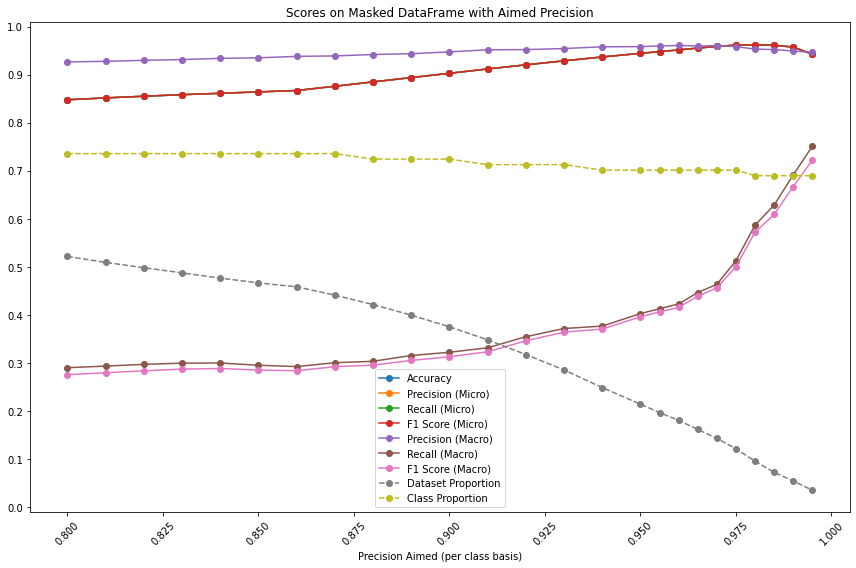

In [91]:
plot_aimed_precision(data)

Confusion Matrix

In [23]:
p_aim = 0.95
masked_data =mask_creater(p_aim,data)
plot_confusion_matrices( masked_data, save_path=None,aimed=True)

[2023-07-06 07:28:54] Plotting Confusion Matrix for 0.0
[2023-07-06 07:28:56] Plotting Confusion Matrix for 0.25
[2023-07-06 07:28:59] Plotting Confusion Matrix for 0.5
[2023-07-06 07:29:01] Plotting Confusion Matrix for 0.75
Saved in /srv/phyto-plankton-classification/models/2023-06-05_143422/results/confusion/confusion_aimed


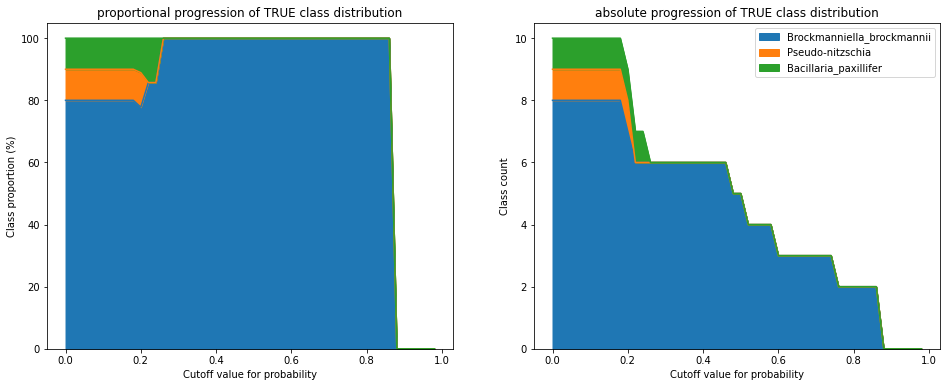

In [126]:

data
# Define the range for iterations
myrange = np.arange(0, 1, 0.02)
z=0
for cl in np.unique(data["top1"]):
    compo = pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts())
    for j, i in enumerate(myrange):
        slice = data[data["probability"] > i]
        x = slice[slice['top1']==cl]["true_label"].value_counts()
        compo[str(j)] = x

    compo = compo.drop("true_label", axis=1)
    plotdata = compo / compo.sum()
    perc_data = plotdata[plotdata > 0.01] * 100
    total = compo[plotdata > 0.01]
    z+=1
    if z==9:
        break
    # find_cut=[]
    # for i in myrange:
    #     find_cut.append(perc_data[i][0]*np.sum(total))


    
try:
    compo = compo.drop("true_label", axis=1)
except:
    pass
plotdata = compo / compo.sum()
plotdata1 = plotdata[plotdata > 0.01] * 100
plotdata2 = compo[plotdata > 0.01]
plotdata1.columns = myrange
plotdata2.columns = myrange
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plotdata1.dropna(how="all").transpose().plot.area(ax=axs[0], legend=False,
                                                        title="proportional progression of TRUE class distribution",
                                                        xlabel="Cutoff value for probability",
                                                        ylabel="Class proportion (%)")
plotdata2.dropna(how="all").transpose().plot.area(ax=axs[1],
                                                        title="absolute progression of TRUE class distribution",
                                                        xlabel="Cutoff value for probability",
                                                        ylabel="Class count")
plotdata2=plotdata2.fillna(0)
tot=pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts()).loc[cl]
find_cut=[]
for iter,value in enumerate(plotdata.loc[cl]):
    left=(plotdata2.iloc[:,iter].values[0])
    find_cut.append((left*tot).values[0])
        

In [127]:
find_cut=find_cut
max_index = find_cut.index(max(find_cut))

In [130]:
find_cut

[64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 56,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 48.0,
 40.0,
 40.0,
 32.0,
 32.0,
 32.0,
 32.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 24.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [125]:
find_cut

[array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([64]),
 array([56]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([48.]),
 array([40.]),
 array([40.]),
 array([32.]),
 array([32.]),
 array([32.]),
 array([32.]),
 array([24.]),
 array([24.]),
 array([24.]),
 array([24.]),
 array([24.]),
 array([24.]),
 array([24.]),
 array([24.]),
 array([16.]),
 array([16.]),
 array([16.]),
 array([16.]),
 array([16.]),
 array([16.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.])]

<AxesSubplot:title={'center':'absolute progression of TRUE class distribution'}, xlabel='Cutoff value for probability', ylabel='Class count'>

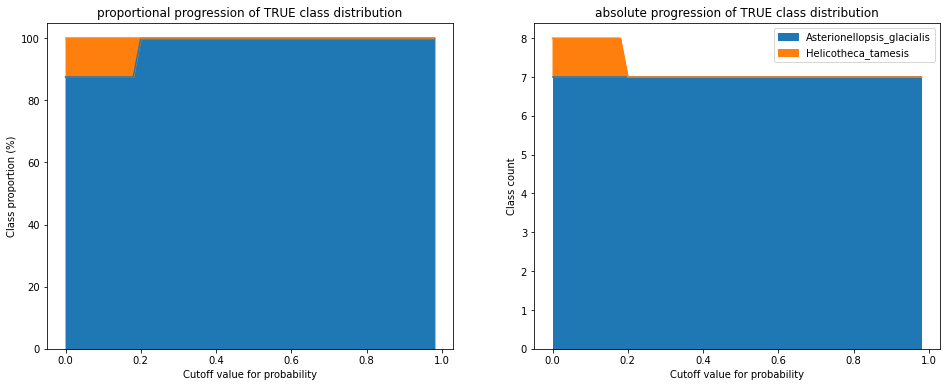

In [21]:
# compo = compo.drop("true_label", axis=1)
plotdata = compo / compo.sum()
plotdata1 = plotdata[plotdata > 0.01] * 100
plotdata2 = compo[plotdata > 0.01]
plotdata1.columns = myrange
plotdata2.columns = myrange
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plotdata1.dropna(how="all").transpose().plot.area(ax=axs[0], legend=False,
                                                        title="proportional progression of TRUE class distribution",
                                                        xlabel="Cutoff value for probability",
                                                        ylabel="Class proportion (%)")
plotdata2.dropna(how="all").transpose().plot.area(ax=axs[1],
                                                        title="absolute progression of TRUE class distribution",
                                                        xlabel="Cutoff value for probability",
                                                        ylabel="Class count")

In [37]:
np.sum(plotdata2[0.00].values)
np.sum(plotdata2.iloc[:,0].values)

8

In [61]:
cl

'Asterionellopsis_glacialis'

In [63]:
pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts()).loc[cl]

true_label    7
Name: Asterionellopsis_glacialis, dtype: int64

In [43]:
np.sum(plotdata2.iloc[:,0].values)/np.sum(pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts()))

true_label    1.0
dtype: float64

In [53]:
plotdata2=plotdata2.fillna(0)


In [66]:
plotdata

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Asterionellopsis_glacialis,0.875,0.875,0.875,0.875,0.875,0.875,0.875,0.875,0.875,0.875,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Helicotheca_tamesis,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
np.sum(plotdata2.iloc[:,iter].values)

7.0

In [69]:
plotdata2

,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98
Asterionellopsis_glacialis,7,7,7,7,7,7,7,7,7,7,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
Helicotheca_tamesis,1,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
tot=pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts()).loc[cl]
for iter,value in enumerate(plotdata.loc[cl]):
    left=(plotdata2.iloc[:,iter].values[0])
    

0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
0.875 7 6.125
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0
1.0 7.0 7.0


In [106]:
value

0.875

In [98]:
float(value)

0.875

In [105]:
print(float(value) * float(left)* float(left),
float(left) - float(value),
float(left) / float(value))

1.1428571428571428 0.2678571428571428 1.3061224489795917


In [11]:
# Define the range for iterations
myrange = np.arange(0, 1, 0.02)

# Create directory for saving results
# pred_path = create_pred_path(save_path, dir="proportional_progression",comments=comments)


for cl in np.unique(data["top1"]):
    print(f"Plotting proportional progression for {cl}")
    compo = pd.DataFrame(data[data['top1'] == cl]["true_label"].value_counts())
    for j, i in enumerate(myrange):
        slice = data[data["probability"] > i]
        x = slice[slice['top1']==cl]["true_label"].value_counts()
        compo[str(j)] = x
    break

Plotting proportional progression for Actinoptychus_senarius


In [12]:
compo

,true_label,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
Actinoptychus_senarius,8,8,8,8,8,8,8,8,8,8,...,7,7,7,7,7,5,5,4,3,2


In [6]:
perc_data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Actinoptychus_senarius,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:

def propose_cutoff(data, cl, p_aim=0.8, r_aim=0.8, step = 0.05):
    i =0
    p = 0
    r = 0
    while (p < p_aim or r < r_aim) and i < 1:
        i += step
        slice = data[data["probability"] > i]
        data_slice.append(np.sum(slice['top1'] == cl) / np.sum(data['top1'] == cl))
        TPFP = np.sum(slice["top1"] == cl)
        TP = np.sum((slice["true_label"] == cl) & (slice["top1"] == cl))
        TPFN = np.sum(slice["true_label"] == cl)
        p = TP / TPFP  # intuitively the ability of the classifier not to label as positive a sample that is negative
        r = TP / TPFN  # intuitively the ability of the classifier to find all the positive samples